## **Definition**

Kalman filtering is an iterative mathematical process that uses a set of equations and consecutive data inputs to estimate the true value of one or more magnitudes when the measured values contain unpredicted or random error, uncertainty or variation.

## **Overall description**

The Kalman filter computation is performed as a closed loop of linear operators that are recursively computed over time. The Kalman filter keeps record of an internal state that its updated at each iteration to predict the next timestamp state. This state is then updated (or corrected) using the measured input at this timestamp.

The Kalman filter explicitly models the noise present in the estimated state as well as the noise present in the measured input. To model the noise, the covariance is used. All types of noise are assumed to follow a Gaussian distribution, so the estimation using Kalman filter is only optimal in this case. However, it may provide good results when other types of noise are present.


There are three main steps in the Kalman filter algorithm:
*   Prediction. Given the previous state, the current state prediction for the next timestamp is computed.
*   Update. Given the predicted state and the measured input for this timestmap, the current state is computed.
*   Current become previous. When a new Kalman filter iteration starts, the current state becomes the previous state.



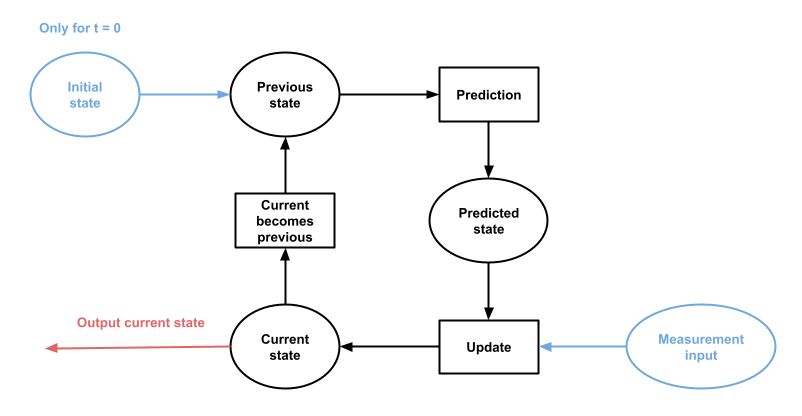

Now let's see the variables and equations implied in each stage. We will explain them in detail afterwards.

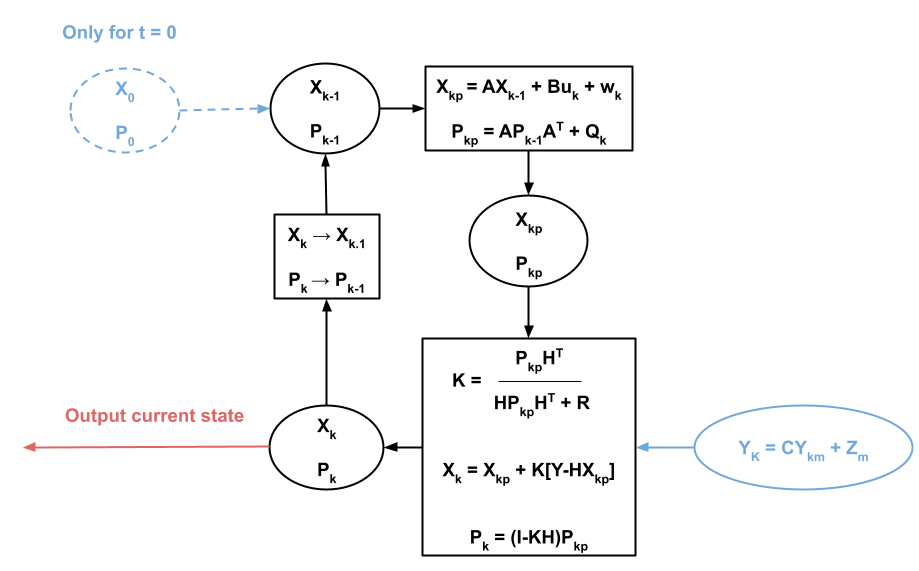

## **Prediction**

We often refer generally to the state of the Kalman filter, but in practice, the state is composed of two components.
*   A state vector. A vector that contains a value for all the mangitudes that we are modelling / tracking with the Kalman filter.
*   The process covariance matrix. A matrix containing the covariance associated to all the variables present in the state vector.





In our example, we want to track the position of the object at each time instant. Also, normally we include the velocity in the state vector. So the state vector for our example is:
$$X = \begin{bmatrix}x\\
\dot{x}\\
\end{bmatrix}$$

The state prediction equation computes a state prediction $X_{kp}$ given the previous state $X_{k-1}$ and the control vector $u_k$.

$$X_{kp} = A X_{k-1} + B u_k + w_k$$

$A$ is the state transition model. In our example, it serves predict the current position and velocity given the previous position and velocity.

$$A = \begin{bmatrix}1 && dt\\
0 && 1\\
\end{bmatrix}$$

$B$ is the control-input model. It is used to model any input for which we know the value at each instant and affects the state.

$$B = \begin{bmatrix}\frac{dt^2}{2} \\
dt \\
\end{bmatrix}$$

In [ ]:
# Import modules used in this notebook
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

In [ ]:
# General parameters used in this notebook
dt = 1.0

In [ ]:
def predict_state(A, X_prev, B, u, w):
  X = np.matmul(A, X_prev) + B * u + w
  return X

def predict_process_noise(A, P_prev, Q):
  P = np.matmul(A, np.matmul(P_prev, A.T)) + Q
  return P

def predict(A, X_prev, P_prev, B, u, w, Q):
  X = predict_state(A, X_prev, B, u, w)
  P = predict_process_noise(A, P_prev, Q)
  return [X, P]

In [ ]:
# Test code for the prediction methods
A = np.array([[1, dt],[0, 1]]) 
X_prev = np.array([[1],[0]])
B = np.array([[dt**2/2],[dt]])
u = 1
w = np.array([[0],[0]])

P_prev = np.array([[1000, 0],[0, 1000]])
Q = np.array([[1, 0],[0, 1]])
[X, P] = predict(A, X_prev, P_prev, B, u, w, Q)
print(X)
print(P)

[[1.5]
 [1. ]]
[[2001. 1000.]
 [1000. 1001.]]


## **Update**

In the update stage, first the Kalman gain is computed.

$H$ is the observation model, which maps the true state space into the observed space.

$R$, the covariance of the observation noise.


In [ ]:
def compute_kalman_gain(P_pred, H, R):
  K = np.matmul(P_pred, H.T)/(np.matmul(H, np.matmul(P_pred, H.T)) + R)
  return K

def update_state(X_pred, K, Y, H):
  X = X_pred + np.matmul(K, Y - np.matmul(H, X_pred))
  return X

def update_process_noise(K, H, P_pred):
  KH = np.dot(K, H)
  I = np.eye(KH.shape[1])
  P = np.dot(I - KH, P_pred)
  return P

def update(X_pred, P_pred, H, R, Y):
  K = compute_kalman_gain(P_pred, H, R)
  X = update_state(X_pred, K, Y, H)
  P = update_process_noise(K, H, P_pred)
  return [X, P]

In [ ]:
# Test code for update methods
P_pred = np.array([[2001, 1000],[1000, 2001]])
H = np.eye(P_pred.shape[1])
R =  np.array([[10, 0],[0, 1]])
Y = np.array([[1.5],[0]])
X_pred = np.array([[1],[0]])
[X, P] = update(X_pred, P_pred, H, R, Y)
print(X)
print(P)


[[1.49751367]
 [0.5       ]]
[[ -990.0497265  -1996.02734958]
 [-2000.5004995   -999.0004995 ]]


## **Example**

To better understand the Kalman filter let's create a simple example. Let's assume an object moving in a 1D straight line and that at $t = 0\;s$, the initial position is $0\;m$ and the initial speed is also $0\;\frac{m}{s}$. Let's assume that from $t=0\;s$ s to $t=10\;s$ the object has an acceleration of $1\;\frac{m}{s^2}$, from $t=10\;s$ to $t=15\;s$ the acceleration is $0\;\frac{m}{s^2}$ and from $t=15\;s$ to $t=20\;s$ the acceleration is $-2\;\frac{m}{s^2}$. 

Text(0.5, 1.0, 'Acceleration vs Time')

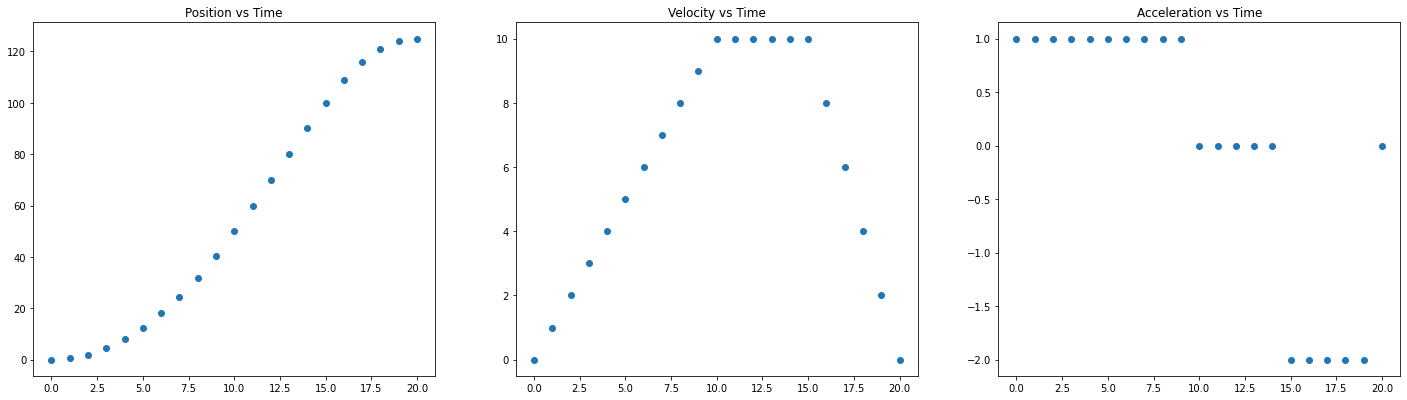

In [ ]:
# One sample per second from 0 s to 20 s
t = np.arange(0, 21, dt)

# Init acceleration array
a = np.zeros(t.shape)
a[0 : 10] = 1
a[15 : 20] = -2

# Compute velocity array (v = v_prev + a_prev * Δt)
v = np.zeros(t.shape)
v[1:] = np.cumsum(a)[:-1] * dt

# Compute position array (x = x_prev + v_prev * Δt + (a_prev * Δt^2)/2)
x = np.zeros(t.shape)
x[1:] = (np.cumsum(v)[:-1] + np.cumsum(a/2)[:-1] * dt) * dt

# Plot position versus time
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24.5, 6.5)
ax1.scatter(t, x)
ax1.set_title('Position vs Time')
ax2.scatter(t, v)
ax2.set_title('Velocity vs Time')
ax3.scatter(t, a)
ax3.set_title('Acceleration vs Time')

These parameters describe the real movement of the object, but when applying the Kalman filter we will assume that we don't know these parameters and we have to estimate the position of the vehicle at each time $t$. 

Now let's prepare a method that enables us to test the Kalman filter prediction for this sequence modifying different input parameters, and one method to compare the real input values and the estimated ones.

In [ ]:
def do_kalman_simulation(x, v, a, dt, w, Q, R, x0, v0):
  # Set initial values
  X_prev = np.array([[x0],[v0]])
  P_prev = np.array([[1, 0],[0, 1]])
  # Set matrixes
  A = np.array([[1, dt],[0, 1]]) 
  B = np.array([[dt**2/2],[dt]])
  u = 1
  H = np.eye(P_prev.shape[1])
  # w = np.array([[0],[0]])
  # Q = np.array([[0.01, 0],[0, 0.01]])
  # R =  np.array([[10, 0],[0, 10]])
  # Output vector
  kalman_x = [0.0]
  kalman_v = [0.0]
  for i in range(1, len(t)):
    u = a[i-1]
    [X_pred, P_pred] = predict(A, X_prev, P_prev, B, u, w, Q)
    Y = np.array([[x[i]],[v[i]]])
    [X, P] = update(X_pred, P_pred, H, R, Y)
    kalman_x.append(X[0][0])
    kalman_v.append(X[1][0])
    [X_prev, P_prev] = [X, P]
  return [kalman_x, kalman_v]

def plot_results(t, x, v, x_noisy, v_noisy, kalman_x, kalman_v):
  # Plot position versus time
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(16.2, 6.5)

  ax1.scatter(t, x, s = 200)
  ax1.scatter(t, x_noisy, s = 100)
  ax1.scatter(t, kalman_x, s = 50)  
  ax1.set_title('Position vs Time')
  ax2.scatter(t, v, s = 200)
  ax2.scatter(t, v_noisy, s = 100)
  ax2.scatter(t, kalman_v, s = 50)  
  ax2.set_title('Velocity vs Time')


First let's simulate a situation where there is no noise. The Kalman estimated position and velocity perfectly follow the true values. This is because the Kalman filter integrates the movement equations, and without input noise, there is no noise reduction filtering applied.

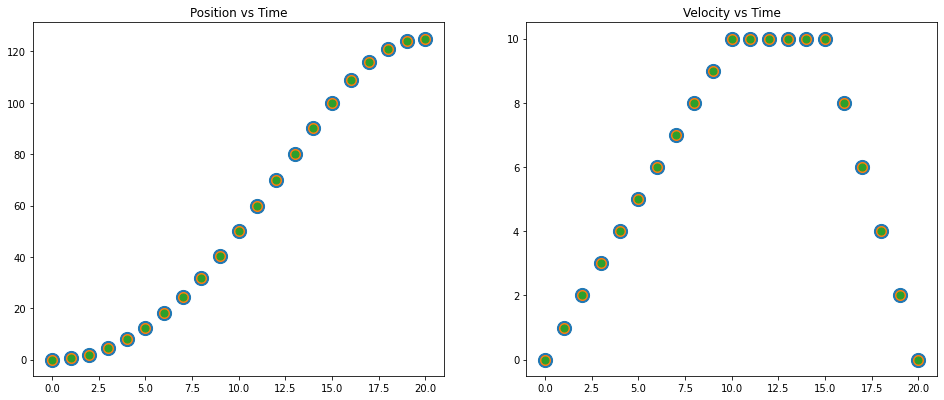

In [ ]:
w = np.array([[0],[0]])
Q = np.array([[0.01, 0],[0, 0.01]])
R =  np.array([[10, 0],[0, 10]])
x_noisy = x
v_noisy = v
a_noisy = a
[kalman_x, kalman_v] = do_kalman_simulation(x, v, a, dt, w, Q, R, 0, 0)
plot_results(t, x, v, x_noisy, v_noisy, kalman_x, kalman_v)

Now let's assume a case where the measured inputs and the control input have a certain amount of noise. With the elements in the diagonal of the R matrix, we model the variance of the input's noise. 


*   If we establish low noise values in R (diagonal elements), the Kalman filter output will closely resemble the input.
*   On the other hand, if we establish a high expected variance for the input noise, the Kalman filter output will follow the model values (using the control acceleration) and discarding the input measurements of position and velocity.
*   In the intermediate case, if we assign accurate estimations of the input measurements variance, we will obtain optimal estimations of the position and velocity.



Average error position estimation: 7.985461000533564
Average error position estimation: 26.341732190103034
Average error position estimation: 4.434189358390797


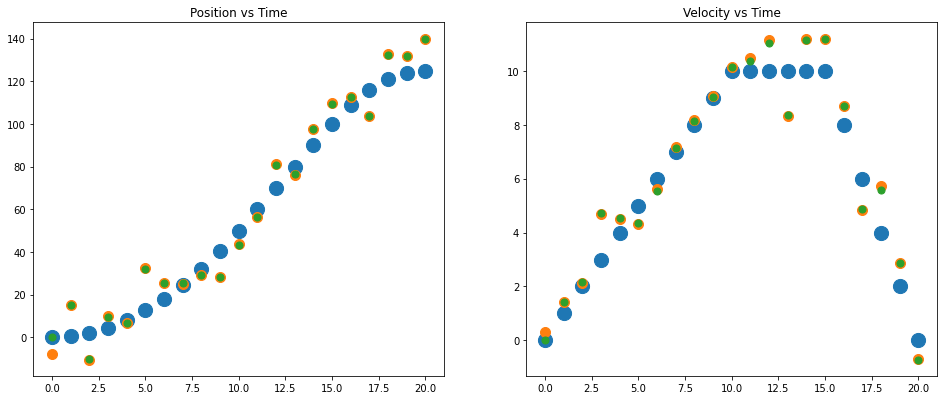

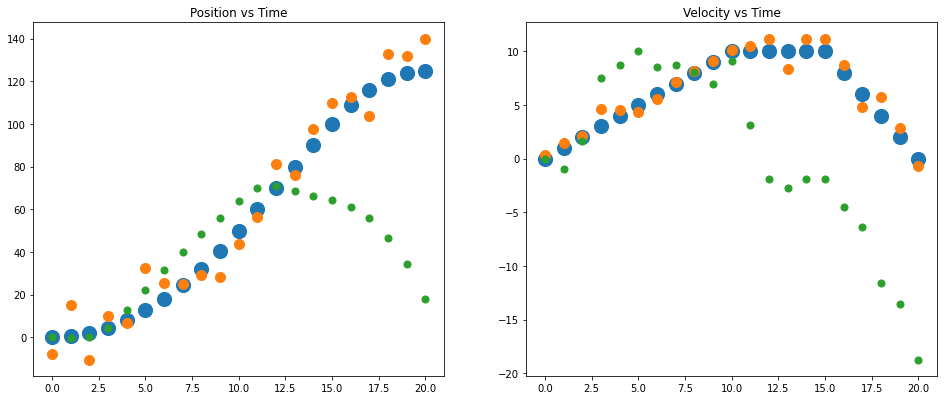

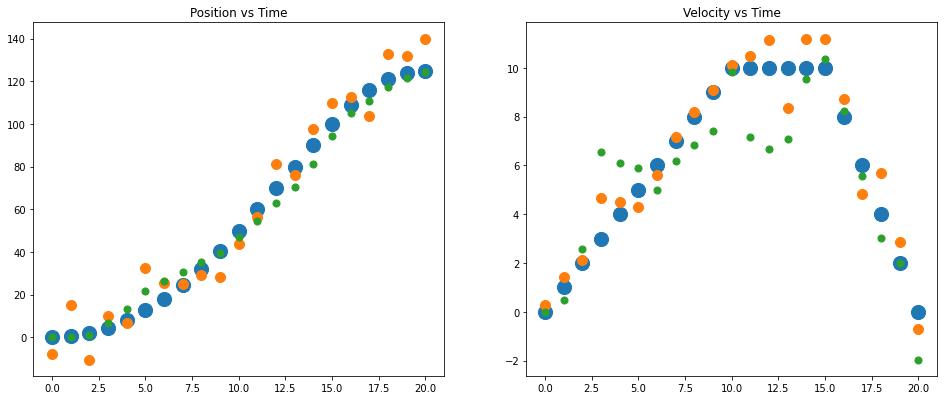

In [ ]:
w = np.array([[0],[0]])
Q = np.array([[0.5, 0.0],[0.0, 0.5]])
R =  np.array([[0.01, 10000000000.0],[10000000000.0, 0.01]])
x_noisy = x + np.random.normal(0, 10.0, len(x))
v_noisy = v + np.random.normal(0, 1.0, len(v))
a_noisy = a + np.random.normal(0, 2.0, len(v))
[kalman_x, kalman_v] = do_kalman_simulation(x_noisy, v_noisy, a_noisy, dt, w, Q, R, 0, 0)
plot_results(t, x, v, x_noisy, v_noisy, kalman_x, kalman_v)
avg_error_x = mean(abs(a - b) for a, b in zip(x, kalman_x))
print('Average error position estimation: ' + str(avg_error_x))

R =  np.array([[10000000000.0, 10000000000.0],[10000000000.0, 10000000000.0]])
[kalman_x, kalman_v] = do_kalman_simulation(x_noisy, v_noisy, a_noisy, dt, w, Q, R, 0, 0)
plot_results(t, x, v, x_noisy, v_noisy, kalman_x, kalman_v)
avg_error_x = mean(abs(a - b) for a, b in zip(x, kalman_x))
print('Average error position estimation: ' + str(avg_error_x))

R =  np.array([[100.0, 10000000000.0],[10000000000.0, 1.0]])
[kalman_x, kalman_v] = do_kalman_simulation(x_noisy, v_noisy, a_noisy, dt, w, Q, R, 0, 0)
plot_results(t, x, v, x_noisy, v_noisy, kalman_x, kalman_v)
avg_error_x = mean(abs(a - b) for a, b in zip(x, kalman_x))
print('Average error position estimation: ' + str(avg_error_x))
